
# 004 · Visual Similarity (In-Stock First) — English Version
**Logic preserved; comments fully in English.**  
This notebook builds a KNN-based visual recommender **only over in-stock items**, with:
- **Color-code–based dedup** at `(item_id, color)` level to avoid same-color multi-angle duplicates
- **Optional gender filter**
- **OOS-aware rule (auto)**: if the **Query item is out of stock**, exclude the **same item & same color** from results; otherwise allow it
- **Similarity-only metric**: AvgSimilarity@K (no hit-rate metrics)
- A simple visualization helper


In [15]:

# %% [Setup] Imports & robust paths
from pathlib import Path
import os, re, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.neighbors import NearestNeighbors

plt.rcParams['figure.dpi'] = 110

NB_DIR = Path.cwd()
CANDIDATES = [NB_DIR/'data', NB_DIR.parent/'data', NB_DIR.parent.parent/'data']

DATA_DIR = None
for cand in CANDIDATES:
    if (cand/'features.npy').exists() and (cand/'keys.csv').exists():
        DATA_DIR = cand
        break
if DATA_DIR is None:
    DATA_DIR = NB_DIR/'data'

FEAT_PATH = DATA_DIR/'features.npy'
KEYS_PATH = DATA_DIR/'keys.csv'
IMG_ROOT  = DATA_DIR / "img"   # all image paths are relative to /data/img/


print(f"Notebook folder: {NB_DIR}")
print(f"Data folder    : {DATA_DIR}")
print(f"features.npy   : {FEAT_PATH.exists()}")
print(f"keys.csv       : {KEYS_PATH.exists()}")

assert FEAT_PATH.exists(), f"features.npy not found: {FEAT_PATH}"
assert KEYS_PATH.exists(),  f"keys.csv not found: {KEYS_PATH}"


Notebook folder: d:\Icey\tcd\notebooks\dMining\Group Project\workflow\notebooks
Data folder    : d:\Icey\tcd\notebooks\dMining\Group Project\workflow\data
features.npy   : True
keys.csv       : True


In [16]:

# %% [Load] Data + basic normalization
F = np.load(FEAT_PATH)
keys = pd.read_csv(KEYS_PATH)

assert 'image_path' in keys.columns or 'image_name' in keys.columns,     "keys.csv must contain 'image_path' or 'image_name'"
if 'image_path' not in keys.columns:
    keys['image_path'] = keys['image_name']

keys['image_path'] = keys['image_path'].astype(str).str.replace('\\', '/', regex=False)

def parse_gender_from_path(p: str) -> str:
    p = str(p).replace('\\','/').strip().upper()
    if p.startswith('MEN/'): return 'MEN'
    if p.startswith('WOMEN/'): return 'WOMEN'
    return ''

if 'gender_norm' not in keys.columns:
    keys['gender_norm'] = keys['image_path'].apply(parse_gender_from_path)
else:
    keys['gender_norm'] = keys['gender_norm'].fillna('').astype(str).str.upper().str.strip()

if 'in_stock' not in keys.columns:
    keys['in_stock'] = 1
keys['in_stock'] = keys['in_stock'].fillna(1).astype(int)

print(F.shape, len(keys))
keys.head(3)


(26830, 2048) 26830


,image_path,item_id,eval_split,in_stock,gender,category,gender_norm
0,WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg,id_00000001,gallery,1,WOMEN,Blouses_Shirts,WOMEN
1,WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg,id_00000001,query,1,WOMEN,Blouses_Shirts,WOMEN
2,WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg,id_00000001,gallery,1,WOMEN,Blouses_Shirts,WOMEN


In [17]:

# %% [Prep] Color-code parser & OOS switch (auto)
COLOR_RE = re.compile(r'^(\d{2,})_')

def parse_color_code(p: str) -> str:
    try:
        name = Path(str(p)).name
        m = COLOR_RE.match(name)
        return m.group(1) if m else ''
    except Exception:
        return ''

QUERY_OOS_MODE = 'auto'

def effective_query_oos(q_idx: int) -> bool:
    if QUERY_OOS_MODE == 'force_oos':
        return True
    if QUERY_OOS_MODE == 'force_instock':
        return False
    if 'in_stock' in keys.columns:
        try:
            return int(keys.iloc[q_idx]['in_stock']) == 0
        except Exception:
            return False
    return False


In [18]:

# %% [Index] Build KNN on in-stock gallery
mask_gal = (keys['in_stock'].values == 1) & (keys['eval_split'].values == "gallery")
K_gal = keys[mask_gal].reset_index(drop=False).rename(columns={'index':'orig_index'})
F_gal = F[mask_gal]
orig_idx = K_gal['orig_index'].to_numpy()

knn = NearestNeighbors(n_neighbors=200, metric='euclidean')
knn.fit(F_gal)

print(f"Gallery (in-stock) size: {len(K_gal)}; Feature dim: {F.shape[1]}")
K_gal.head(3)


Gallery (in-stock) size: 12612; Feature dim: 2048


,orig_index,image_path,item_id,eval_split,in_stock,gender,category,gender_norm
0,0,WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg,id_00000001,gallery,1,WOMEN,Blouses_Shirts,WOMEN
1,2,WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg,id_00000001,gallery,1,WOMEN,Blouses_Shirts,WOMEN
2,4,WOMEN/Tees_Tanks/id_00000007/01_1_front.jpg,id_00000007,gallery,1,WOMEN,Tees_Tanks,WOMEN


In [19]:

# %% [Search] In-stock KNN + exclude same (item,color) only when Query is OOS + (item,color) dedup
def run_knn_on_instock_strict(q_idx: int, topn: int = 200, enforce_gender: bool = True, query_oos_mode: str = None) -> pd.DataFrame:
    qrow    = keys.iloc[q_idx]
    q_item  = str(qrow.get('item_id', ''))
    q_gender= str(qrow.get('gender_norm','')).upper().strip()
    q_color = parse_color_code(qrow['image_path'])

    _mode = query_oos_mode or QUERY_OOS_MODE
    q_is_oos = effective_query_oos(q_idx) if _mode == 'auto' else (_mode == 'force_oos')

    q_vec = F[q_idx].reshape(1, -1)
    dist_local, idx_local = knn.kneighbors(q_vec, n_neighbors=topn)

    #dist_local = dist_local[0]; idx_local = idx_local[0]
    #sim_local  = 1.0 - dist_local
    #sim_local = 1.0 / (1.0 + dist_local)

    dist_local = dist_local[0]; idx_local = idx_local[0]
    # --- 在当前这次 KNN 结果里做 min-max 归一化 ---
    d_min = dist_local.min()
    d_max = dist_local.max()
    eps   = 1e-9

    # 距离越小，相似度越接近 1；距离越大，相似度越接近 0
    sim_local = 1.0 - (dist_local - d_min) / (d_max - d_min + eps)


    global_rows = orig_idx[idx_local]
    cand = keys.iloc[global_rows].copy()
    cand['distance']   = dist_local
    cand['similarity'] = sim_local
    

    if enforce_gender and q_gender:
        cand = cand[cand['gender_norm'].astype(str).str.upper().eq(q_gender)].copy()

    cand['color_code'] = cand['image_path'].apply(parse_color_code)

    if q_is_oos:
        mask_same = (cand['item_id'].astype(str).eq(q_item)) & (cand['color_code'].astype(str).eq(q_color))
        cand = cand[~mask_same].copy()

    cand.sort_values('similarity', ascending=False, inplace=True)
    cand = cand.drop_duplicates(subset=['item_id', 'color_code'], keep='first')

    note = []
    for _, r in cand.iterrows():
        if str(r['item_id']) == q_item and str(r['color_code']) != q_color:
            note.append('same ID (different color)')
        else:
            note.append('')
    cand['note'] = note

    return cand[['image_path','item_id','gender_norm','similarity','distance','color_code','note']].reset_index(drop=True)

_ = run_knn_on_instock_strict(0, topn=50).head(3)


In [27]:

# %% [Metrics • FAST] AvgSimilarity@K (similarity-only; respects OOS rule)
gal_item   = K_gal['item_id'].astype(str).values if 'item_id' in K_gal.columns else np.array(['']*len(K_gal))
gal_gender = K_gal['gender_norm'].astype(str).values if 'gender_norm' in K_gal.columns else np.array(['']*len(K_gal))
gal_color  = K_gal['image_path'].apply(parse_color_code).astype(str).values

q_item_all   = keys['item_id'].astype(str).values if 'item_id' in keys.columns else np.array(['']*len(keys))
q_gender_all = keys['gender_norm'].astype(str).values if 'gender_norm' in keys.columns else np.array(['']*len(keys))
q_color_all  = keys['image_path'].apply(parse_color_code).astype(str).values

if 'eval_split' in keys.columns:
    q_idx_list = keys.index[keys['eval_split'].astype(str).str.lower().eq('query')].tolist()
    if len(q_idx_list) == 0:
        q_idx_list = list(range(min(200, len(keys))))
else:
    q_idx_list = list(range(min(200, len(keys))))

ENFORCE_SAME_GENDER = True
TOPN_TEST = 500

Q_mat = F[np.array(q_idx_list)]
dist_gal, idx_gal = knn.kneighbors(Q_mat, n_neighbors=TOPN_TEST)
# --- 新增：针对每个 query 行做 min-max，把距离映射到 [0,1] 再反转 ---
eps    = 1e-9
d_min  = dist_gal.min(axis=1, keepdims=True)          # 每一行的最小距离
d_max  = dist_gal.max(axis=1, keepdims=True)          # 每一行的最大距离
sim_gal = 1.0 - (dist_gal - d_min) / (d_max - d_min + eps)



def avg_similarity_after_rule(K: int) -> float:
    vals = []
    for pos, qi in enumerate(q_idx_list):
        qg = q_gender_all[qi]
        q_item  = q_item_all[qi]
        q_color = q_color_all[qi]
        q_is_oos = effective_query_oos(qi) if QUERY_OOS_MODE == 'auto' else (QUERY_OOS_MODE == 'force_oos')

        gals = idx_gal[pos]
        sims = sim_gal[pos]

        kept = []
        seen = set()
        for j in range(len(gals)):
            gi = gals[j]
            if ENFORCE_SAME_GENDER and qg and gal_gender[gi] != qg:
                continue
            if q_is_oos and gal_item[gi] == q_item and gal_color[gi] == q_color:
                continue
            key = (gal_item[gi], gal_color[gi])
            if key in seen:
                continue
            seen.add(key)
            kept.append(sims[j])
            if len(kept) >= K:
                break

        if kept:
            vals.append(float(np.mean(kept)))
    return float(np.mean(vals)) if vals else 0.0

KLIST = [1,5,10,20]
metric_df = pd.DataFrame([[K, avg_similarity_after_rule(K)] for K in KLIST],
                         columns=['K','AvgSimilarity'])
metric_df


,K,AvgSimilarity
0,1,0.994304
1,5,0.843206
2,10,0.763949
3,20,0.676900


In [28]:
# ==== 选择用于判断“同类别”的字段 ====
CAT_COL = "category"   # TODO: 改成你真实的“类别”字段名，比如 "category"

if CAT_COL not in keys.columns:
    raise ValueError(f"列 {CAT_COL} 不在 keys 中，请把 CAT_COL 改成你实际的类别列名（例如 'category'）。")

if CAT_COL not in K_gal.columns:
    raise ValueError(f"列 {CAT_COL} 不在 K_gal 中，请确认 gallery 用的表里也有同名类别列。")

# gallery & query 的类别数组
gal_cat   = K_gal[CAT_COL].astype(str).values
q_cat_all = keys[CAT_COL].astype(str).values

# ==== Metrics • FAST: Precision@K（按“同类别”为相关）====

def precision_at_k_after_rule(K: int) -> float:
    """
    Precision@K（同类别为“相关”）：
    在已经应用业务规则(性别过滤、OOS过滤、去重)后，
    P@K = (# Top-K 中属于同一产品类别的推荐数) / K
    """
    vals = []
    for pos, qi in enumerate(q_idx_list):
        qg       = q_gender_all[qi]
        q_item   = q_item_all[qi]
        q_color  = q_color_all[qi]
        q_cat    = q_cat_all[qi]
        # 你原来就有的逻辑：根据 QUERY_OOS_MODE 判断 query 是否视为 OOS
        q_is_oos = effective_query_oos(qi) if QUERY_OOS_MODE == 'auto' else (QUERY_OOS_MODE == 'force_oos')

        gals = idx_gal[pos]   # 这一条 query 的候选 gallery 索引（按相似度排序）

        kept_labels = []      # 记录 Top-K 内每个候选是否“相关”（1 / 0）
        seen = set()          # 去重用：同 (item, color) 只算一次

        for j in range(len(gals)):
            gi = gals[j]

            # 1) 性别过滤
            if ENFORCE_SAME_GENDER and qg and gal_gender[gi] != qg:
                continue

            # 2) OOS 过滤：若 query 当作 OOS，则排除完全同 item + color 的 exact item
            if q_is_oos and gal_item[gi] == q_item and gal_color[gi] == q_color:
                continue

            # 3) 去重（同一 (item, color) 只保留一个）
            key = (gal_item[gi], gal_color[gi])
            if key in seen:
                continue
            seen.add(key)

            # 4) “相关”定义：同一产品类别
            is_rel = (gal_cat[gi] == q_cat)
            kept_labels.append(1.0 if is_rel else 0.0)

            # 收齐 Top-K 就停
            if len(kept_labels) >= K:
                break

        if not kept_labels:
            # 没有任何有效候选 → 这条 query 的 P@K 视为 0
            vals.append(0.0)
        else:
            # 标准定义：分母用 K（就算候选不足 K 也除以 K，偏严格）
            rel_cnt = sum(kept_labels)
            vals.append(rel_cnt / K)

    return float(np.mean(vals)) if vals else 0.0

# KLIST = [1,5,10] 已经在上面定义过
p_rows = [[K, precision_at_k_after_rule(K)] for K in KLIST]
p_at_k_df = pd.DataFrame(p_rows, columns=['K', 'P@K'])
p_at_k_df

# 把 P@K 合并到你之前的 metric_df（里面已有 AvgSimilarity）
#metric_df = metric_df.merge(p_at_k_df, on='K', how='left')
#metric_df




,K,P@K
0,1,0.659586
1,5,0.571402
2,10,0.532009
3,20,0.495337


In [23]:

# %% [Viz] Query vs Top-K (in-stock; OOS-aware same-color exclusion; dedup)
def _abs(rel: str):
    return (IMG_ROOT / str(rel).replace('\\','/')).resolve()

def show_topk_instock_dedup(q_idx: int = 0, K: int = 5, enforce_gender: bool = True, query_oos_mode: str = None):
    q = keys.iloc[q_idx]
    q_img   = _abs(q['image_path'])
    q_color = parse_color_code(q['image_path'])

    _mode   = query_oos_mode or QUERY_OOS_MODE
    eff_oos = effective_query_oos(q_idx) if _mode == 'auto' else (_mode == 'force_oos')

    res  = run_knn_on_instock_strict(q_idx, topn=200, enforce_gender=enforce_gender, query_oos_mode=_mode)
    tops = res.sort_values('similarity', ascending=False).head(K).reset_index(drop=True)

    fig, axes = plt.subplots(1, K+1, figsize=(3*(K+1), 3.6))
    try:
        axes[0].imshow(Image.open(q_img).convert('RGB'))
    except Exception:
        axes[0].text(0.5,0.5,'(image missing)',ha='center',va='center')
    status = 'OOS' if eff_oos else 'IN-STOCK'
    axes[0].set_title(f"QUERY [{status}]\n{q.get('item_id','')}\n{q.get('gender_norm','')}")
    axes[0].axis('off')

    for j, r in tops.iterrows():
        p = _abs(r['image_path'])
        try:
            axes[j+1].imshow(Image.open(p).convert('RGB'))
        except Exception:
            axes[j+1].text(0.5,0.5,'(missing)',ha='center',va='center')
        tag = ''
        if str(r.get('item_id','')) == str(q.get('item_id','')):
            if parse_color_code(r['image_path']) != q_color:
                tag = ' (same ID diff color)'
            else:
                tag = ' (same ID same color)'  # only if query treated as IN-STOCK
        axes[j+1].set_title(f"#{j+1} s={r['similarity']:.3f}{tag}")
        axes[j+1].axis('off')

    plt.tight_layout()
    plt.show()

# Example:
# show_topk_instock_dedup(q_idx=0, K=5)


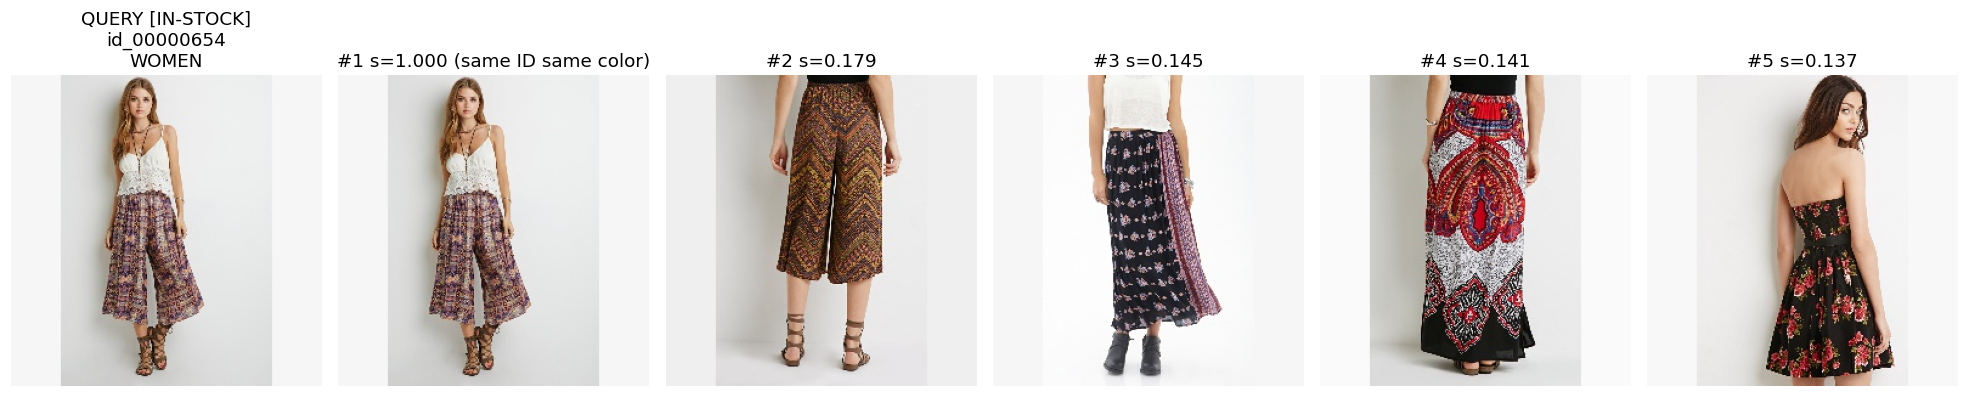

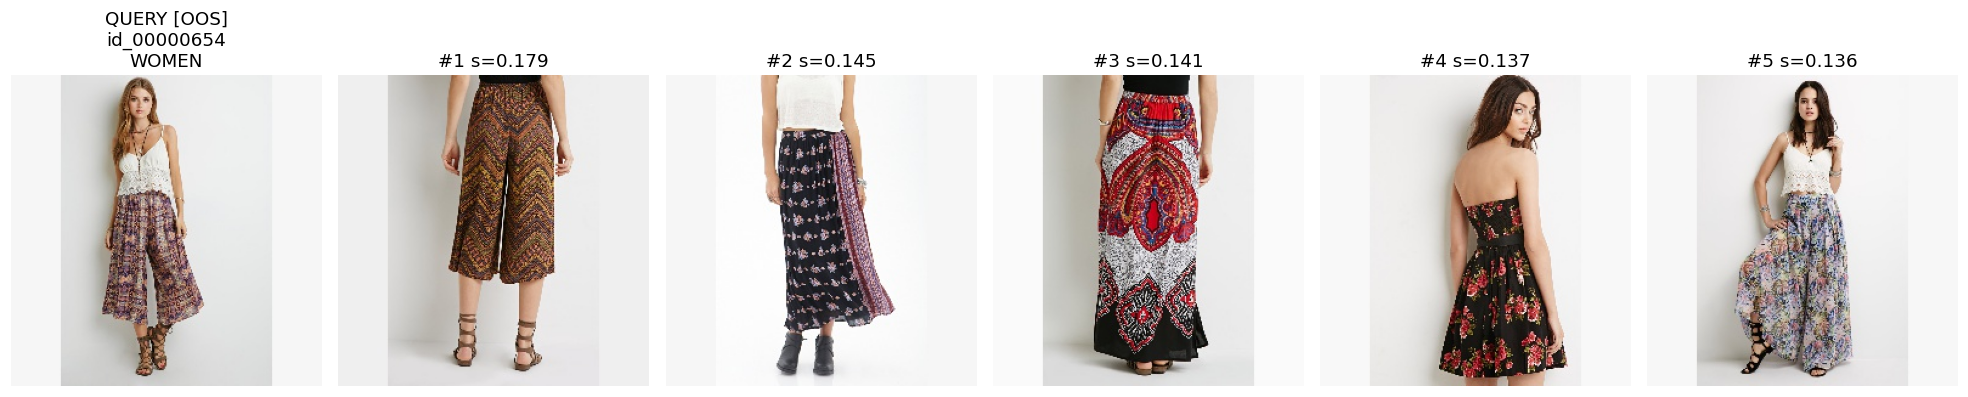

In [24]:
# Example:
show_topk_instock_dedup(q_idx=2005, K=5) # auto mode(base on stock status)
show_topk_instock_dedup(q_idx=2005, K=5, query_oos_mode='force_oos')